# Python и машинное обучение: нейронные сети и компьютерное зрение

## Модуль 3. Сверточные нейронные сети (CNN)

Convolutional Neural Networks, "Сверточные Нейросети". Применение операции "свертка" в нескольких слоях нейросети - революционное решение, которое позволило радикально повысить качество решения задач компьютерного зрения. Впервые было продемонстировано Яном Лекуном в Париже в 1993 году в задаче "распознавание рукописных цифр" (датасет MNIST).

В данном модуле рассмотрим процесс создания и обучение сверточных нейросетей в PyTorch:
- операция "свертка", определение, реализация в PyTorch;
- создание многослойной нейронной сети со сверточными слоями и распознавание рукописных цифр:
    - добавление сверточных слоев,
    - слои-объединения (max-pooling),
    - пакетная нормализация (batch normalization);
- задача бинарной классификации на примере набора полноцвентых изображений "кошки против собак", обучение нейросети с "ноля";
- дообучение готовых моделей, загруженных из интернета (на примере модели архитектуры ResNet-50).





In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

from torch.nn.functional import normalize

from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Операция "Свертка" (Convolution)

Выполнение операции "двумерная свертка" (convolution 2D) иллюстрирует анимированное изображение ниже. Суть операции в следующем:
- ядро свертки - квадратная матрица размером $n * n$
- по матрице размера $M * N$ , над которой выполняется операция "свертка"  запускается "окно" размером с ядро свертки ($n * n$), оно двигается слева направо, сверху вниз,с заданным шагом (stride);
- на каждом шаге происходит поэлементное умножение ядра свертки на содержимое текущего "окна", происходит суммирование произведения (операция эквивалентна скалярному произведению "плоских" представлений соотв. матриц);
- результат записывается в соответствующую ячейку результирующей матрицы.

![Convolution Gif](./conv.gif)

На данном изображении к исходной матрице применяется свертка со следующим ядром:

```
 0 1 2 
 2 2 0 
 0 1 2
```

Запустим "свертку" на изображении.

Для этого создадим сверточный слой вне сети и запустим в нем некоторую свертку поверх изображения Лены.

In [ ]:
from PIL import Image, ImageFilter  

lena = Image.open('lena.jpg')

display(lena)

t_lena = transforms.ToTensor()(lena)

print(t_lena.shape)

In [ ]:
# создаем сверточный слой вне сети
conv = nn.Conv2d(in_channels=1, # принимает одноканальное изображение размером (1, 256, 256)
                 out_channels=1, # отдает тоже одноканальное изображение размером (1, 254, 254) 
                 kernel_size=3, # ядро размера 3х3
                 padding=0, 
                 bias=False)
# обратите внимание на размер тензора весов сети
# assert conv.weight.shape == (OUT_CHANNELS, IN_CHANNELS, KERNEL_SIZE, KERNEL_SIZE)
conv.weight.shape

In [ ]:
# сделаем Лену одноканальной, чтобы передать ее в сверточный слой
t_lena_bw = (t_lena.sum(axis=0) / 3).unsqueeze(0)

display( transforms.ToPILImage()( t_lena_bw ) )

In [ ]:
# возьмем для примера "вертикальное" ядро детектора краев Собеля-Фельдмана 
kernel = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype =torch.float32)

# разрешаем копировать веса и копируем их
with torch.no_grad():
    conv.weight.copy_( kernel )
    
out_img = conv(t_lena_bw)
out_img


In [ ]:
# нормализуем вывод
out_img -= out_img.min()
out_img /= out_img.max()

display( transforms.ToPILImage()( out_img ) )


### Практика

1. В коде вверху поэкпериментируйте с другими значениями весов ядра свертки. Поищите в интернете веса для других фильтров, попробуйте их применить на исходном изображении.

2. Реализуйте детектор краев Собеля-Фельдмана. То, что мы уже получили - это матрица градиентов по вертикальной оси. Используя вертикально "отзеркаленное" и транспонированное ядро, нужно получить матрицу градиентов по горизонтальной оси, а затем вычислить квадратный корень из их суммы: $G = \sqrt{G_x^2 + G_y^2}$. Номализуйте полученное изображение и выведите его на экран.

Суть метода Собеля-Фельдмана:
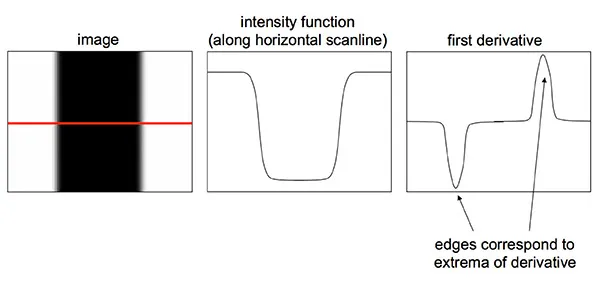

Ядра сверток:
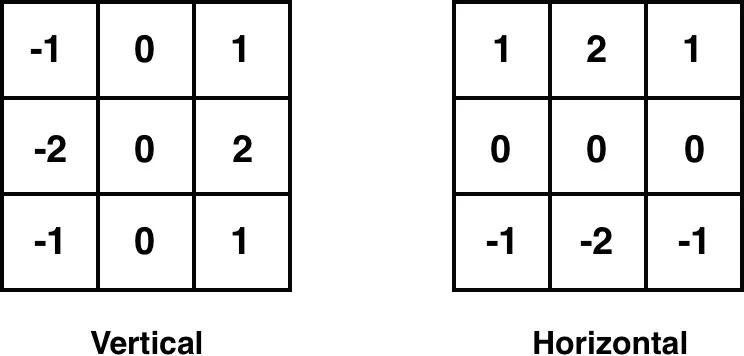

Итоговое изображение:
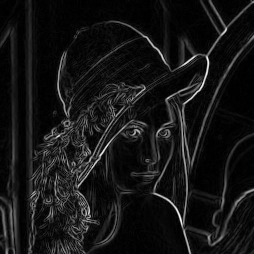

<small>Источник: 
1. https://www.adeveloperdiary.com/data-science/computer-vision/how-to-implement-sobel-edge-detection-using-python-from-scratch/
2. https://www.reg.ru/blog/svyortka-v-deep-learning-prostymi-slovami/    
    
</small>

In [ ]:
kernel_v = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype =torch.float32)

kernel_h = kernel_v.flip(1).T

# ваш код здесь


### Обучение нейросети на наборе данных MINST

Это те же "рукописные цифры", только с разрешением 28x28 пикселей и в количестве 10000 экзепляров. Инструменты для работы с ним есть во всех фреймворках для работы с нейросетями. PyTorch - не исключение.

In [ ]:
from torchvision import datasets

mean, std = 0.1307, 0.3081

mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])

trainset = datasets.MNIST('./data', download=True, train=True, transform=mnist_transforms)
valset = datasets.MNIST('./data', download=True, train=False, transform=mnist_transforms)

print(len(trainset))
print(len(valset))

In [ ]:
batch_size=128

train_generator_MNIST = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_generator_MNIST = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

## Сверточная сеть архитектуры LeNet-5

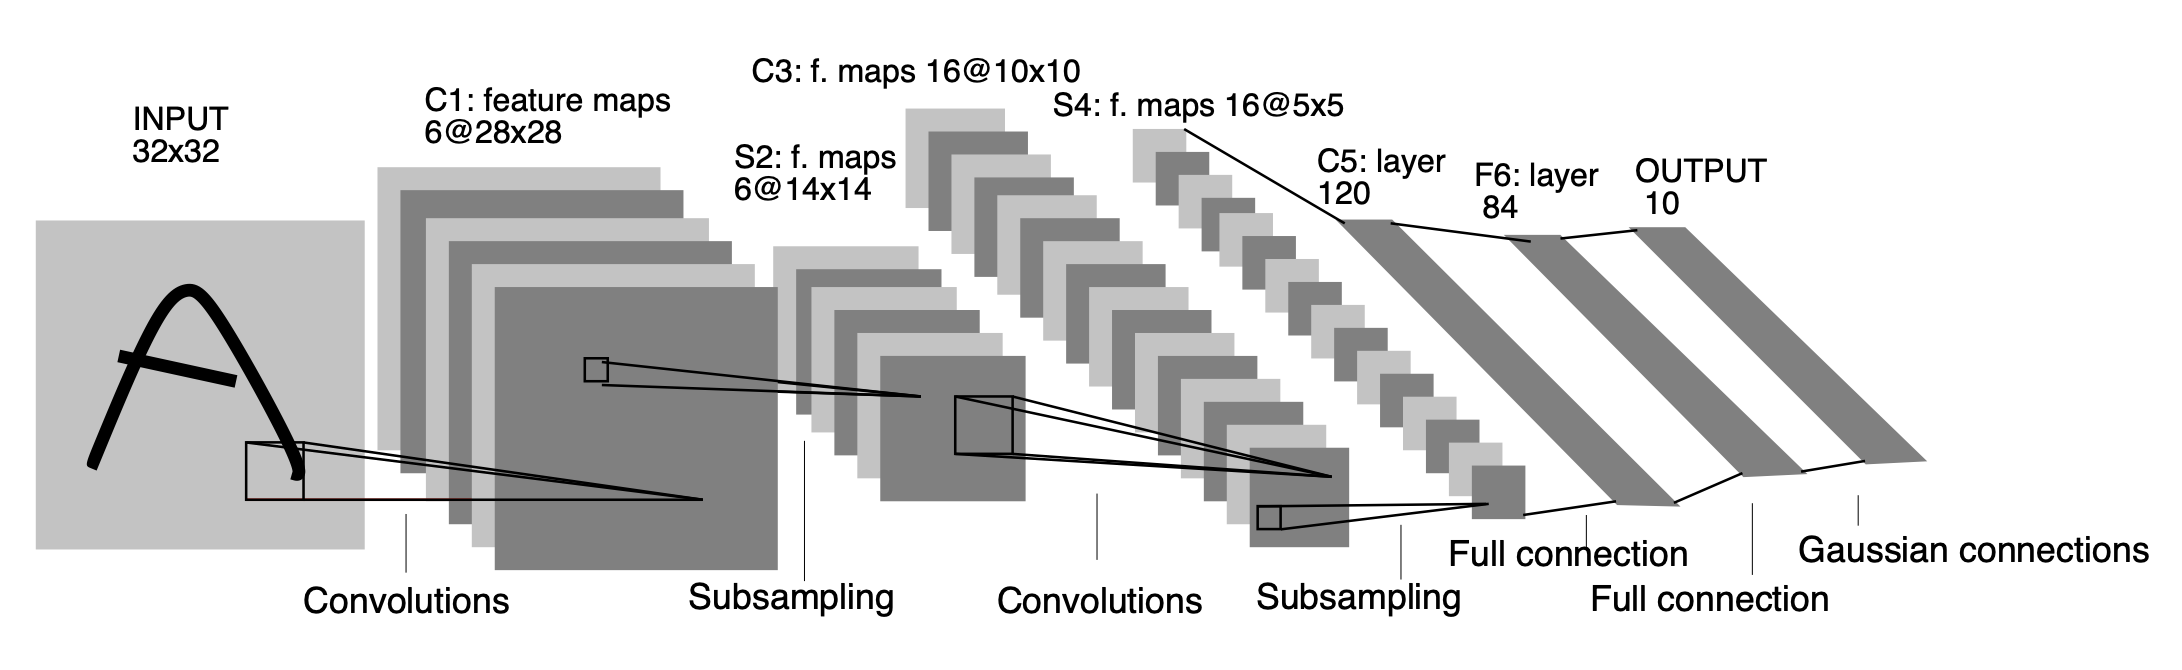

In [ ]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))